Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 92, 10)            60        
                                                                 
 max_pooling1d (MaxPooling1  (None, 46, 10)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 20)            1020      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 21, 20)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 420)               0     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


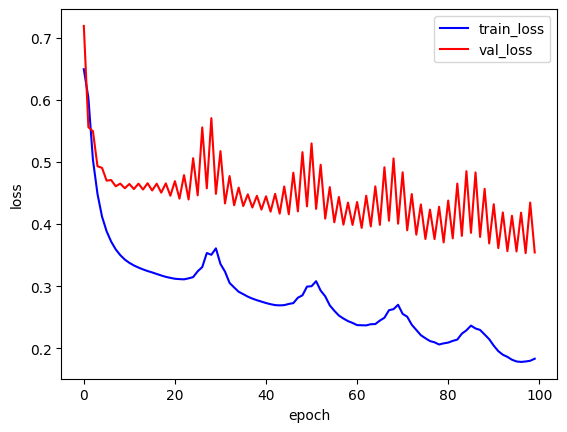

Accuracy on train: 0.8799999952316284
Accuracy on test: 0.8299999833106995
4/4 [==============================] - 0s 4ms/step
Accuracy on test: 0.83


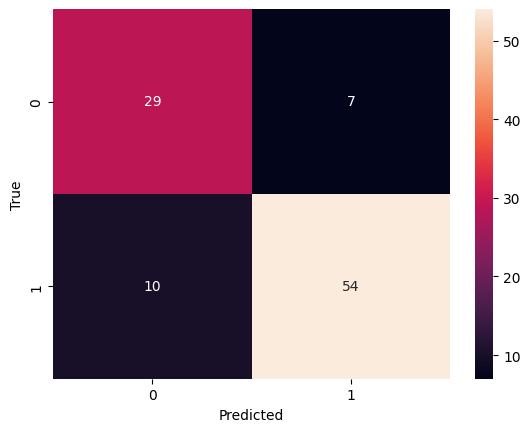

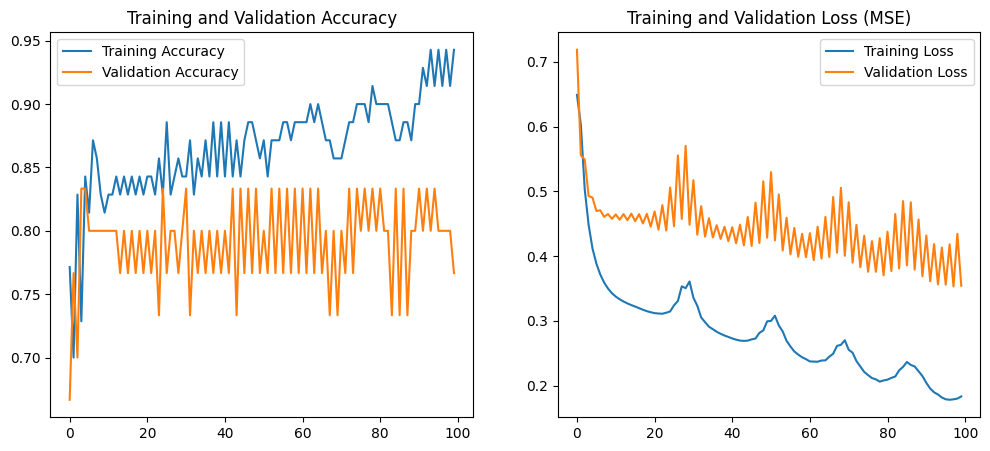

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        36
           1       0.89      0.84      0.86        64

    accuracy                           0.83       100
   macro avg       0.81      0.82      0.82       100
weighted avg       0.83      0.83      0.83       100



In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# restart keras and tensorflow session
keras.backend.clear_session()

# Charger les données ECG200
url_train = "https://maxime-devanne.com/datasets/ECG200/ECG200_TRAIN.tsv"
url_test = "https://maxime-devanne.com/datasets/ECG200/ECG200_TEST.tsv"

ecg_train = np.genfromtxt(url_train, delimiter='\t')
ecg_test = np.genfromtxt(url_test, delimiter='\t')

# Extraire les labels et les features
x_train, y_train = ecg_train[:, 1:], ecg_train[:, 0]
x_test, y_test = ecg_test[:, 1:], ecg_test[:, 0]

# Reduire la taille de l'ensemble d'entrainement pour accélérer l'entraînement
nnn = 1000
x_train = x_train[:nnn]
y_train = y_train[:nnn]

# Transformer les labels en représentation binaire
encoder = LabelEncoder()
y_train_binary = encoder.fit_transform(y_train)
y_test_binary = encoder.transform(y_test)

# Ajoute une dimension pour le temps dans les données d'entraînement et de test
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Nombre de classes (binaire dans ce cas)
nb_classes = 2

# Architecture du modèle
input_shape = (x_train.shape[1], x_train.shape[2])  # Maintenant, la forme inclut la dimension du temps
input_layer = keras.layers.Input(input_shape)

# create the first convolution layer and link it to the input layer
hidden_conv_layer_1 = keras.layers.Conv1D(filters=10, kernel_size=5, strides=1, activation='relu')(input_layer)
hidden_pooling_layer_1 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(hidden_conv_layer_1)

# create the second convolution which takes as input the previous pooling
hidden_conv_layer_2 = keras.layers.Conv1D(filters=20, kernel_size=5, strides=1, activation='relu')(hidden_pooling_layer_1)
hidden_pooling_layer_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='valid')(hidden_conv_layer_2)

# Flatten the output before the dense layer
flattened_layer = keras.layers.Flatten()(hidden_pooling_layer_2)

# Dense layer
dense_layer = keras.layers.Dense(units=100, activation='relu')(flattened_layer)

# Output layer
output_layer = keras.layers.Dense(units=nb_classes, activation='softmax')(dense_layer)

# create the model by specifying input and output
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.summary()

# Compilation du modèle
learning_rate = 0.1
optimizer_algo = keras.optimizers.SGD(learning_rate=learning_rate)
cost_function = keras.losses.sparse_categorical_crossentropy
model.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])

# Entraînement du modèle
model_checkpoint = keras.callbacks.ModelCheckpoint('best-model.h5', monitor='val_loss', save_best_only=True)

mini_batch_size = 256
nb_epochs = 100
percentage_of_train_as_validation = 0.3

history = model.fit(x_train, y_train_binary, batch_size=mini_batch_size,
                    epochs=nb_epochs, verbose=False,
                    validation_split=percentage_of_train_as_validation,
                    callbacks=[model_checkpoint])

history_dict = history.history
loss_train_epochs = history_dict['loss']
loss_val_epochs = history_dict['val_loss']

plt.figure()
plt.plot(loss_train_epochs,color='blue',label='train_loss')
plt.plot(loss_val_epochs,color='red',label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('epoch-loss.pdf')
plt.show()
plt.close()


# Évaluation du modèle
model = keras.models.load_model('best-model.h5')

loss, acc = model.evaluate(x_train, y_train_binary, verbose=False)
print("Accuracy on train:", acc)

loss, acc = model.evaluate(x_test, y_test_binary, verbose=False)
print("Accuracy on test:", acc)

# Charger le modèle pré-entraîné
model = keras.models.load_model('best-model.h5')

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(x_test)

# Convertir les probabilités prédites en classes
predicted_classes = np.argmax(predictions, axis=1)

# Calculer la précision
accuracy = accuracy_score(y_test_binary, predicted_classes)
print("Accuracy on test:", accuracy)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test_binary, predicted_classes)
# Affichage de la matrice de confusion
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history.get('val_accuracy', [])
val_loss = history.history.get('val_loss', [])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
if val_accuracy:
    plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Créer le graphique pour le MSE
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.legend()

plt.show()

# Afficher le rapport de classification
class_report = classification_report(y_test_binary, predicted_classes)
print("Classification Report:")
print(class_report)